# Data preparing

## old data

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import font_manager, rc
import platform


plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = "NanumGothic"

/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
states1 = pd.read_excel("seoul data.xlsx", parse_dates=["date"], index_col="date", sheet_name="seoul 누적")
states1["infected"] = states1["cumulated confirmed"] - states1["death"] - states1["released"] 

states2 = pd.read_csv("seoul data.csv", index_col=[0,1], header = [0, 1, 2], encoding='cp949')
states2 = states2.transpose()
states2.index.names = ["날짜","구분1","구분2"]
states2.index = states2.index.set_levels(pd.to_datetime(states2.index.levels[0]), level = 0)
states2 = states2.replace("-",0)
states2 = states2[states1.index[-1]+pd.Timedelta(days=1):]

states = pd.concat([states1["infected"], states2["시도별","서울"].loc[:,"격리중","누적"]])
states.index.names = ["date"]
states = states.to_frame()
states = states.rename(columns = { 0 : "infected"})

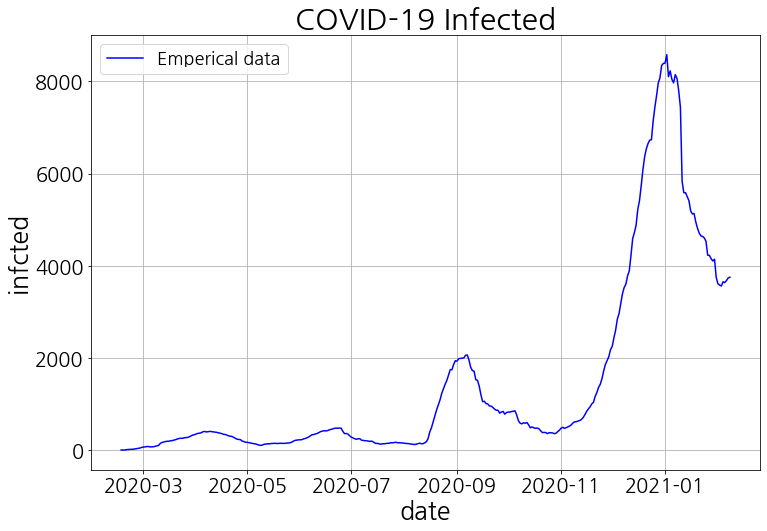

In [3]:
plt.figure(figsize = (12,8))
plt.title("COVID-19 Infected", size = 30)
plt.xlabel("date", fontsize = 25)
plt.ylabel("infcted", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.plot(states, c = "b",label = "Emperical data")

plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show()

In [4]:
states

,infected
date,
2020-02-17,11
2020-02-18,11
2020-02-19,10
2020-02-20,17
2020-02-21,21
...,...
2021-02-04,3655
2021-02-05,3637
2021-02-06,3681


## new data

In [5]:
states_ = pd.read_csv("data/covid19(seoul).csv", index_col=0, usecols = ["서울시 기준일", "서울시 치료중"], encoding='cp949')
states_ = states_.rename(columns = { "서울시 치료중" : "infected"})
states_.index.name = "date"
states_.index = pd.to_datetime(states_.index, format="%y.%m.%d.%H")
states_["infected"] = abs(states_["infected"])
for i in pd.date_range(start = '2020-02-05 00:00:00', end = '2021-05-03 00:00:00'):
    if i not in states_.index.values :
        states_.loc[i] = np.nan
states_ = states_.sort_values(by = "date", ascending=True)
states_["infected"] = states_["infected"].interpolate(method = "linear")
states_.iloc[0] = 8.0
states_new = pd.DataFrame(columns = ["infected"])
states_new.index.name = "date"
for i in pd.date_range(start = '2020-02-05 00:00:00', end = '2021-05-03 00:00:00') :
    if len(states_.loc[i]) == 1:
        states_new.loc[i] = states_.loc[i]
    else :
        states_new.loc[i] = states_.loc[i].values[0,0]
states_new = states_new.reset_index()
states_new

,date,infected
0,2020-02-05,8.0
1,2020-02-06,9.0
2,2020-02-07,10.5
3,2020-02-08,10.0
4,2020-02-09,10.0
...,...,...
449,2021-04-29,2834.0
450,2021-04-30,2912.0
451,2021-05-01,2674.0
452,2021-05-02,2712.0


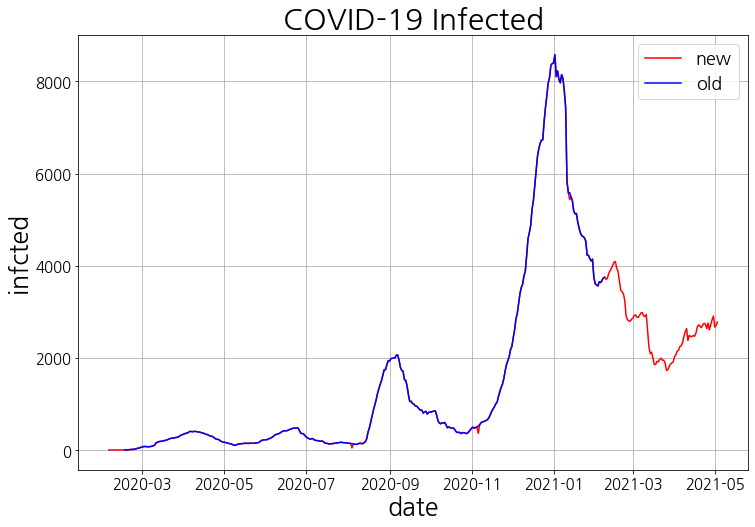

In [6]:
plt.figure(figsize = (12,8))
plt.title("COVID-19 Infected", size = 30)
plt.xlabel("date", fontsize = 25)
plt.ylabel("infcted", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.plot(states_new["date"], states_new["infected"], c = "r", label = "new")
plt.plot(states, c = "b", label = "old")

plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show()

## LSTM (raw data, no time data)

In [7]:
def create_sequences(data, xseq_length, yseq_length):
    xs = []
    ys = []
    for i in range(len(data)-xseq_length-yseq_length+1):
        x = data.iloc[i:(i+xseq_length)]
        y = data.iloc[i+xseq_length : i+xseq_length+yseq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [8]:
states_new

,date,infected
0,2020-02-05,8.0
1,2020-02-06,9.0
2,2020-02-07,10.5
3,2020-02-08,10.0
4,2020-02-09,10.0
...,...,...
449,2021-04-29,2834.0
450,2021-04-30,2912.0
451,2021-05-01,2674.0
452,2021-05-02,2712.0


In [9]:
# sequence 조절

xseq_length = 30
yseq_length = 7
X, y = create_sequences(states_new["infected"], xseq_length, yseq_length)

train_size = states_new[states_new["date"]=="2020-07-18"].index[0]
val_size = states_new[states_new["date"]=="2020-10-28"].index[0] - states_new[states_new["date"]=="2020-07-18"].index[0]
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

mm = MinMaxScaler()

X_train_mm = mm.fit_transform(X_train)
X_val_mm = mm.fit_transform(X_val)
X_test_mm = mm.fit_transform(X_test)

y_train_mm = mm.fit_transform(y_train)
y_val_mm = mm.fit_transform(y_val)
y_test_mm = mm.fit_transform(y_test)

In [10]:
print("training shape", X_train.shape, y_train.shape)
print("validation shape", X_val.shape, y_val.shape)
print("test shape", X_test.shape, y_test.shape)

training shape (164, 30) (164, 7)
validation shape (102, 30) (102, 7)
test shape (152, 30) (152, 7)


In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [12]:
X_train_tensor = Variable(torch.Tensor(X_train_mm))
X_val_tensor = Variable(torch.Tensor(X_val_mm))
X_test_tensor = Variable(torch.Tensor(X_test_mm))

y_train_tensor = Variable(torch.Tensor(y_train_mm))
y_val_tensor = Variable(torch.Tensor(y_val_mm))
y_test_tensor = Variable(torch.Tensor(y_test_mm))

In [13]:
X_train_tensor_final = torch.reshape(X_train_tensor, (X_train_tensor.shape[0], X_train_tensor.shape[1], 1))
X_val_tensor_final = torch.reshape(X_val_tensor, (X_val_tensor.shape[0], X_val_tensor.shape[1], 1))
X_test_tensor_final = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], X_test_tensor.shape[1], 1)) 

In [14]:
print("training shape", X_train_tensor_final.shape, y_train_tensor.shape)
print("validation shape", X_val_tensor_final.shape, y_val_tensor.shape)
print("training shape", X_test_tensor_final.shape, y_test_tensor.shape)

training shape torch.Size([164, 30, 1]) torch.Size([164, 7])
validation shape torch.Size([102, 30, 1]) torch.Size([102, 7])
training shape torch.Size([152, 30, 1]) torch.Size([152, 7])


In [15]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, xseq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.xseq_length = xseq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=0 ,batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.xseq_length, self.hidden_size),
            torch.zeros(self.num_layers, self.xseq_length, self.hidden_size),
        )
    def forward(self,x):
        # Propagate input through LSTM
        output, self.hidden = self.lstm(x.view(self.xseq_length, len(x), -1), self.hidden) #lstm with input, hidden, and internal state
        lstm_output = output.view(self.xseq_length, len(x), self.hidden_size)[-1] #reshaping the data for Dense layer next
        out = self.relu(lstm_output)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [16]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
#     loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
    loss_fn = torch.nn.L1Loss() 
    optimiser = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:
            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [17]:
num_epochs = 500 #number of epochs
learning_rate = 0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 4 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = yseq_length #number of output classes 

In [18]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, xseq_length)

In [19]:
lstm1, train_hist, val_hist = train_model(
    lstm1,
    X_train_tensor_final,
    y_train_tensor,
    X_val_tensor_final,
    y_val_tensor,
    num_epochs=num_epochs,
    verbose=100,
    patience=50
)

Epoch 0 train loss: 0.16259525273358677 val loss: 0.27068281173706055
Epoch 100 train loss: 0.07427234299588813 val loss: 0.1703551560640335
Epoch 200 train loss: 0.07260716813843607 val loss: 0.1636691689491272
Epoch 300 train loss: 0.07079233626818011 val loss: 0.15756255388259888
Epoch 400 train loss: 0.06839698341976079 val loss: 0.15574222803115845


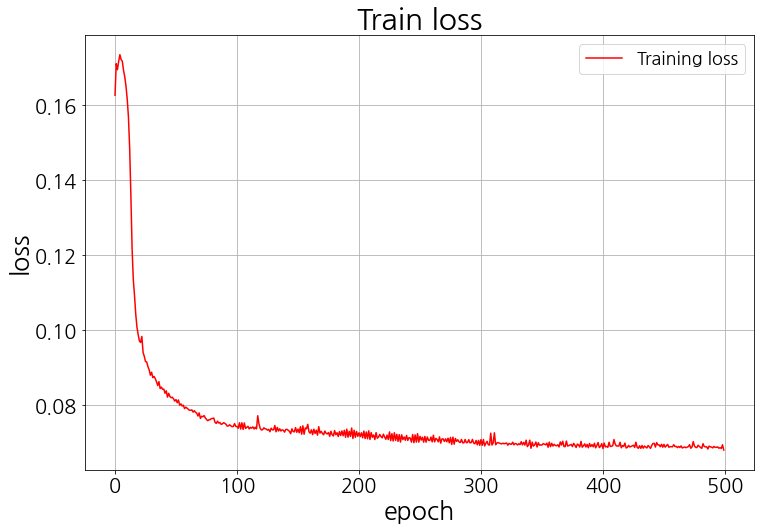

In [20]:
plt.figure(figsize = (12,8))
plt.title("Train loss", size = 30)
plt.xlabel("epoch", fontsize = 25)
plt.ylabel("loss", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.plot(train_hist, c = "r", label="Training loss")

plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show() 

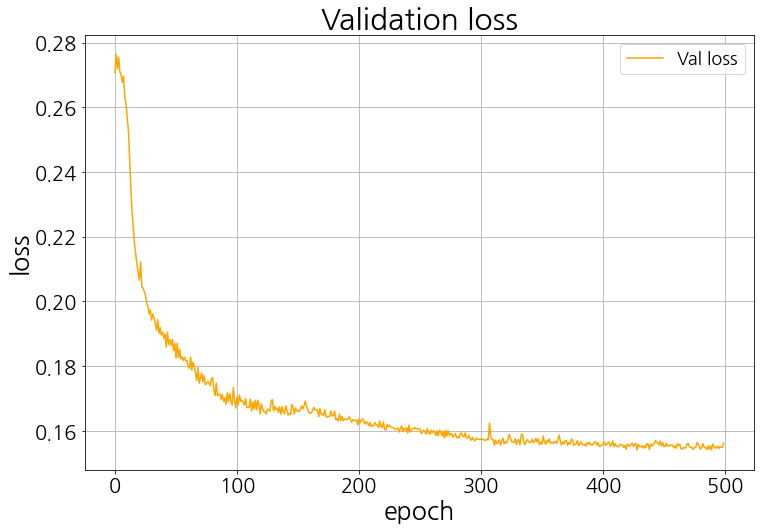

In [21]:
plt.figure(figsize = (12,8))
plt.title("Validation loss", size = 30)
plt.xlabel("epoch", fontsize = 25)
plt.ylabel("loss", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.plot(val_hist, c = "Orange", label="Val loss")

plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show() 

In [22]:
pred_dataset = X_test_tensor_final

with torch.no_grad():
    preds = []
    for i in range(len(pred_dataset)):
        lstm1.reset_hidden_state()
        pred = lstm1(torch.unsqueeze(pred_dataset[i], 0))
        preds.append(np.array(pred).flatten())
preds = np.array(preds)

In [23]:
preds

array([[0.08395419, 0.11090928, 0.11271328, ..., 0.11004678, 0.11625453,
        0.10986893],
       [0.08831698, 0.11561151, 0.11583716, ..., 0.11315145, 0.11931896,
        0.11250837],
       [0.09091175, 0.11840813, 0.11769507, ..., 0.11499794, 0.12114151,
        0.11407816],
       ...,
       [0.17202565, 0.17794845, 0.14592637, ..., 0.0996282 , 0.08774552,
        0.08110126],
       [0.15885   , 0.16798462, 0.14072481, ..., 0.10053974, 0.09134139,
        0.08484666],
       [0.17396569, 0.17966668, 0.14709604, ..., 0.10051706, 0.08842263,
        0.08162332]], dtype=float32)

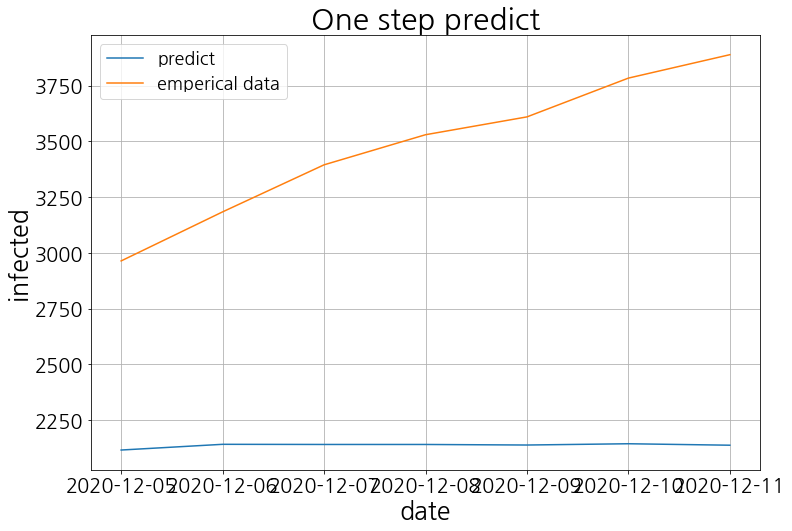

In [24]:
plt.figure(figsize = (12,8))
plt.title("One step predict", size = 30)
plt.xlabel("date", fontsize = 25)
plt.ylabel("infected", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

day = 2

scalemax = y_test.max(axis = 1).reshape(-1,1)
scalemin = y_test.min(axis = 1).reshape(-1,1)

plt.plot(states_new["date"][-len(preds)+day: -len(preds)+yseq_length+day], (scalemin+preds*(scalemax-scalemin))[day], label = "predict")
plt.plot(states_new["date"][-len(preds)+day: -len(preds)+yseq_length+day], states_new["infected"][-len(preds)+day: -len(preds)+yseq_length+day], label = "emperical data")

plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show()

In [25]:
print("MSE : {:,.2f}".format(((preds-y_test_mm)**2).mean()))

MSE : 0.04


## LSTM (Involving $R_t$ data)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

from scipy import stats as sps
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import font_manager, rc
import platform

plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = "NanumGothic"

R_T_MAX = 10
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

GAMMA = 1/12

In [27]:
states_ = pd.read_csv("data/covid19(seoul).csv", index_col=0, usecols = ["서울시 기준일", "서울시 치료중"], encoding='cp949')
states_ = states_.rename(columns = { "서울시 치료중" : "infected"})
states_.index.name = "date"
states_.index = pd.to_datetime(states_.index, format="%y.%m.%d.%H")
states_["infected"] = abs(states_["infected"])
for i in pd.date_range(start = '2020-02-05 00:00:00', end = '2021-05-03 00:00:00'):
    if i not in states_.index.values :
        states_.loc[i] = np.nan
states_ = states_.sort_values(by = "date", ascending=True)
states_["infected"] = states_["infected"].interpolate(method = "linear")
states_.iloc[0] = 8.0
states_new = pd.DataFrame(columns = ["infected"])
states_new.index.name = "date"
for i in pd.date_range(start = '2020-02-05 00:00:00', end = '2021-05-03 00:00:00') :
    if len(states_.loc[i]) == 1:
        states_new.loc[i] = states_.loc[i]
    else :
        states_new.loc[i] = states_.loc[i].values[0,0]
states_new

,infected
date,
2020-02-05,8.0
2020-02-06,9.0
2020-02-07,10.5
2020-02-08,10.0
2020-02-09,10.0
...,...
2021-04-29,2834.0
2021-04-30,2912.0
2021-05-01,2674.0


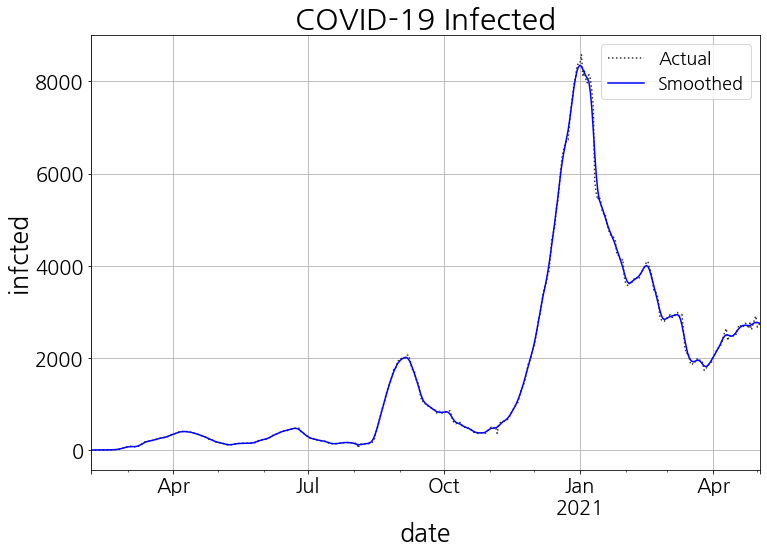

In [28]:
def prepare_cases(cases, cutoff=5):

    smoothed = cases.rolling(7, win_type='gaussian', min_periods=1, center=True).mean(std=2).round()
        
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = cases.loc[smoothed.index]
    
    return original, smoothed

cases = abs(states_new["infected"])
original, smoothed = prepare_cases(cases)

plt.figure(figsize = (12,8))
plt.title("COVID-19 Infected", size = 30)
plt.xlabel("date", fontsize = 25)
plt.ylabel("infcted", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

original.plot(c='k', linestyle=':', alpha=.8, label='Actual')
ax =smoothed.plot(c='b', label='Smoothed')
ax.get_figure().set_facecolor('w')

plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.grid()
plt.show()

In [29]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
        
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range, scale=sigma).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
#     prior0 = sps.gamma(a=1).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(index=r_t_range, columns=sr.index, data={sr.index[0]: prior0})
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma = 100)

In [30]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]

    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()

    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

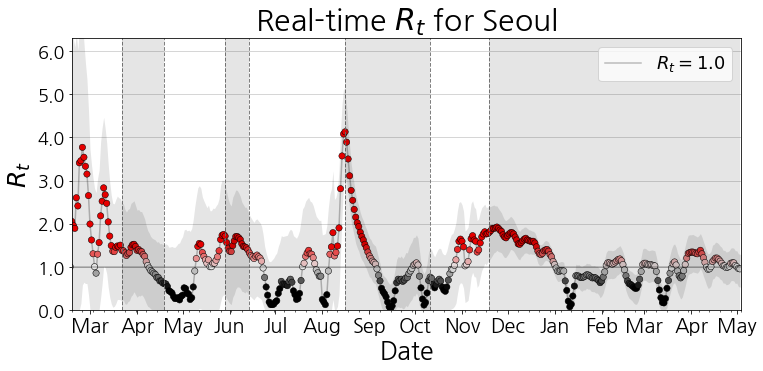

In [31]:
def plot_rt(result, title):
    
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_title(title, size = 30)
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    # Plot dots and line
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    y_min = 0
    y_max = np.max(result['High_90'].values)*0.7
    
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index, values, s=40, lw=.5, c=cmap(color_mapped(values)), edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index), result['Low_90'].values, bounds_error=False, fill_value='extrapolate')
    highfn = interp1d(date2num(index), result['High_90'].values, bounds_error=False, fill_value='extrapolate')
    extended = pd.date_range(start=pd.Timestamp('2020-02-17'), end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha=.1, lw=0, zorder=3)

    ax.axhline(1.0, c='k', lw=1.5, label='$R_t=1.0$', alpha=.25);
    
    ax.axvline(pd.to_datetime("2020-03-22"), color = "grey", lw = 1 , linestyle = "--")
    ax.axvline(pd.to_datetime("2020-04-19"), color = "grey", lw = 1 , linestyle = "--")
    ax.fill_between(pd.date_range("2020-03-22","2020-04-19"), y_min, y_max, color='k', alpha=.1, lw=0, zorder=3)

    ax.axvline(pd.to_datetime("2020-05-29"), color = "grey", lw = 1 , linestyle = "--")
    ax.axvline(pd.to_datetime("2020-06-14"), color = "grey", lw = 1 , linestyle = "--")
    ax.fill_between(pd.date_range("2020-05-29","2020-06-14"), y_min, y_max, color='k', alpha=.1, lw=0, zorder=3)

    
    ax.axvline(pd.to_datetime("2020-08-16"), color = "grey", lw = 1 , linestyle = "--")
    ax.axvline(pd.to_datetime("2020-10-11"), color = "grey", lw = 1 , linestyle = "--")
    ax.fill_between(pd.date_range("2020-08-16","2020-10-11"), y_min, y_max, color='k', alpha=.1, lw=0, zorder=3)

    
    ax.axvline(pd.to_datetime("2020-11-19"), color = "grey", lw = 1 , linestyle = "--")
    ax.fill_between(pd.date_range("2020-11-19",result.index.get_level_values('date')[-1]), y_min, y_max, color='k', alpha=.1, lw=0, zorder=3)

    
    # Formatting
    ax.set_xlabel("Date", size = 25)
    ax.set_ylabel("$R_t$", size = 25)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=18)
    
    ax.grid(axis='y', c='k', alpha=.2, zorder=-2)
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(pd.Timestamp('2020-02-17')+pd.Timedelta(days=1), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    ax.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})

plot_rt(result, title = 'Real-time $R_t$ for Seoul')
plt.show()

In [32]:
infect_reprod = pd.concat([states_new["infected"], result["ML"]], axis=1)
infect_reprod

,infected,ML
date,,
2020-02-05,8.0,0.00
2020-02-06,9.0,1.01
2020-02-07,10.5,2.27
2020-02-08,10.0,1.00
2020-02-09,10.0,1.00
...,...,...
2021-04-29,2834.0,1.09
2021-04-30,2912.0,1.03
2021-05-01,2674.0,1.00


In [33]:
def create_sequences(data, xseq_length, yseq_length):
    xs = []
    ys = []
    for i in range(len(data)-xseq_length-yseq_length+1):
        x = data.iloc[i:(i+xseq_length)].values
        y = data.iloc[i+xseq_length : i+xseq_length+yseq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [34]:
xseq_length = 30
yseq_length = 7

mm = MinMaxScaler()
infect_reprod = pd.DataFrame(mm.fit_transform(infect_reprod), index = infect_reprod.index, columns=["infected", "ML"])
X, y = create_sequences(infect_reprod, xseq_length, yseq_length)

train_size = (datetime.strptime("2020-07-18", "%Y-%m-%d") - datetime.strptime("2020-02-05", "%Y-%m-%d")).days
val_size = (datetime.strptime("2020-10-28", "%Y-%m-%d") - datetime.strptime("2020-07-18", "%Y-%m-%d")).days
X_train, y_train = X[:train_size], y[:train_size,:,0]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size,:,0]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:,:,0]

In [35]:
print("training shape", X_train.shape, y_train.shape)
print("training shape", X_val.shape, y_val.shape)
print("test shape", X_test.shape, y_test.shape)

training shape (164, 30, 2) (164, 7)
training shape (102, 30, 2) (102, 7)
test shape (152, 30, 2) (152, 7)


In [36]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [37]:
X_train_tensor = Variable(torch.Tensor(X_train))
X_val_tensor = Variable(torch.Tensor(X_val))
X_test_tensor = Variable(torch.Tensor(X_test))

y_train_tensor = Variable(torch.Tensor(y_train))
y_val_tensor = Variable(torch.Tensor(y_val))
y_test_tensor = Variable(torch.Tensor(y_test))

X_train_tensor_final = torch.reshape(X_train_tensor, (X_train_tensor.shape[0], X_train_tensor.shape[1], 2))
X_val_tensor_final = torch.reshape(X_val_tensor, (X_val_tensor.shape[0], X_val_tensor.shape[1], 2))
X_test_tensor_final = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], X_test_tensor.shape[1], 2)) 

In [38]:
print("training shape", X_train_tensor_final.shape, y_train_tensor.shape)
print("validation shape", X_val_tensor_final.shape, y_val_tensor.shape)
print("training shape", X_test_tensor_final.shape, y_test_tensor.shape)

training shape torch.Size([164, 30, 2]) torch.Size([164, 7])
validation shape torch.Size([102, 30, 2]) torch.Size([102, 7])
training shape torch.Size([152, 30, 2]) torch.Size([152, 7])


In [39]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, xseq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.xseq_length = xseq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=0 ,batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        self.fc_2 =  nn.Linear(hidden_size, int(hidden_size/2))
        self.fc = nn.Linear(int(hidden_size/2), num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.xseq_length, self.hidden_size),
            torch.zeros(self.num_layers, self.xseq_length, self.hidden_size),
        )
    def forward(self,x):
        # Propagate input through LSTM
        output, self.hidden = self.lstm(x.view(self.xseq_length, len(x), -1), self.hidden) #lstm with input, hidden, and internal state
        lstm_output = output.view(self.xseq_length, len(x), self.hidden_size)[-1] #reshaping the data for Dense layer next
        out = self.relu(lstm_output)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [40]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
#     loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
    loss_fn = torch.nn.L1Loss() 
    optimiser = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:
            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [257]:
num_epochs = 500 #number of epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 20 #number of features in hidden state
num_layers = 2 #number of stacked lstm layers

num_classes = yseq_length #number of output classes 

In [258]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, xseq_length)

In [259]:
lstm1, train_hist, val_hist = train_model(
    lstm1,
    X_train_tensor_final,
    y_train_tensor,
    X_val_tensor_final,
    y_val_tensor,
    num_epochs=num_epochs,
    verbose=50,
    patience=50
)

Epoch 0 train loss: 0.06638031829398398 val loss: 0.10328959673643112
Epoch 50 train loss: 0.014244667836464942 val loss: 0.08861973881721497
Epoch 100 train loss: 0.010325991540079618 val loss: 0.061991531401872635
Epoch 150 train loss: 0.00485864901743409 val loss: 0.06589426845312119

 Early Stopping


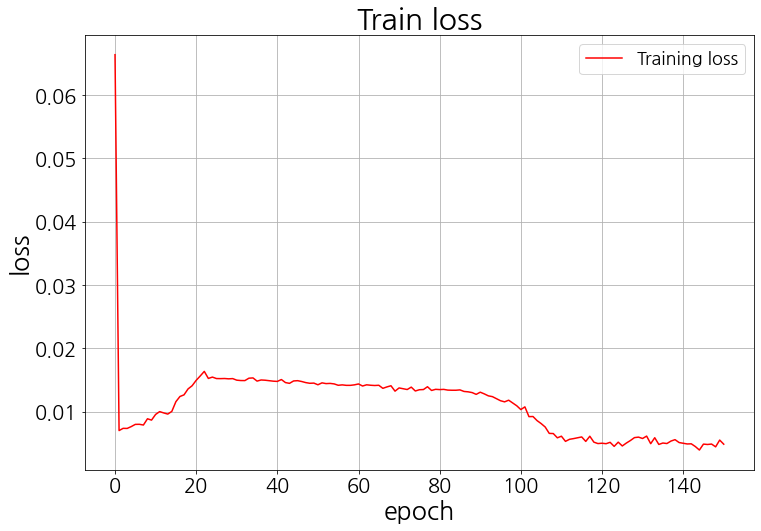

In [260]:
plt.figure(figsize = (12,8))
plt.title("Train loss", size = 30)
plt.xlabel("epoch", fontsize = 25)
plt.ylabel("loss", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.plot(train_hist, c = "r", label="Training loss")

plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show() 

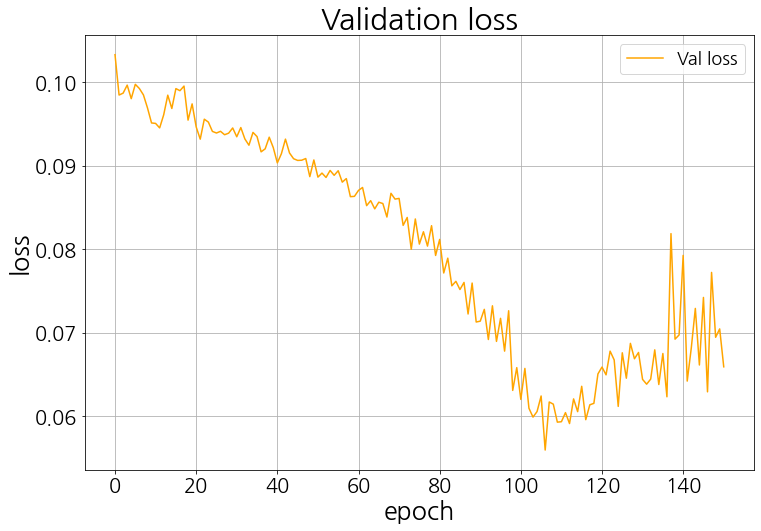

In [261]:
plt.figure(figsize = (12,8))
plt.title("Validation loss", size = 30)
plt.xlabel("epoch", fontsize = 25)
plt.ylabel("loss", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.plot(val_hist, c = "Orange", label="Val loss")

plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show() 

In [262]:
pred_dataset = X_test_tensor_final

with torch.no_grad():
    preds = []
    for i in range(int(len(pred_dataset))):
        lstm1.reset_hidden_state()
        pred = lstm1(torch.unsqueeze(pred_dataset[i], 0))
        preds.append(np.array(pred).reshape(-1))
preds = np.array(preds)

In [275]:
preds

array([[0.04834335, 0.05557076, 0.06423044, ..., 0.07872891, 0.08092417,
        0.08591618],
       [0.04836141, 0.05601795, 0.06518304, ..., 0.08043   , 0.08265533,
        0.08783837],
       [0.04834957, 0.05615693, 0.06550145, ..., 0.08101222, 0.08324791,
        0.08849799],
       ...,
       [0.04830253, 0.0569932 , 0.0673863 , ..., 0.08444114, 0.08673784,
        0.09238063],
       [0.0482986 , 0.05686736, 0.06711678, ..., 0.08395895, 0.08624713,
        0.09183566],
       [0.04830657, 0.05704049, 0.06748434, ..., 0.08461455, 0.0869143 ,
        0.09257635]], dtype=float32)

In [271]:
day = 0
infect_reprod["ML"][train_size+val_size+day*yseq_length:train_size+val_size+(day+1)*yseq_length]

date
2020-10-28    0.280872
2020-10-29    0.338983
2020-10-30    0.384988
2020-10-31    0.397094
2020-11-01    0.384988
2020-11-02    0.353511
2020-11-03    0.246973
Name: ML, dtype: float64

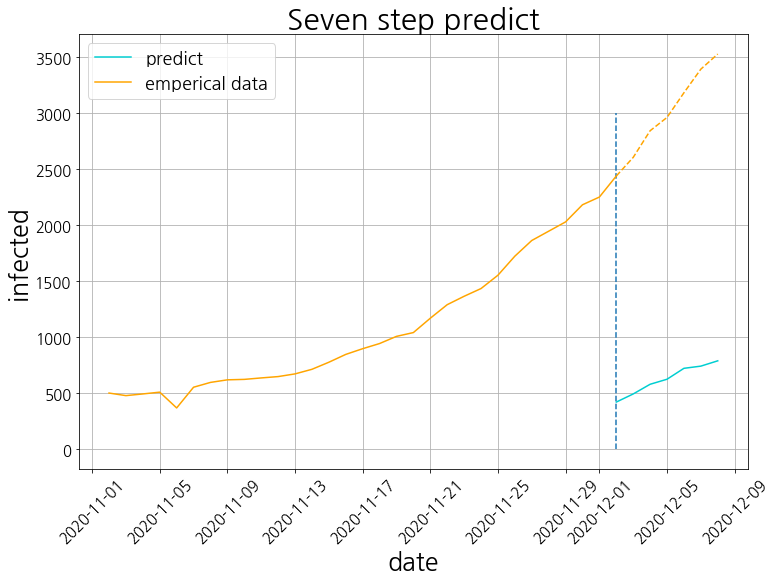

In [264]:
plt.figure(figsize = (12,8))
plt.title("Seven step predict", size = 30)
plt.xlabel("date", fontsize = 25)
plt.ylabel("infected", fontsize = 25)
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)

day = 5

scalemax = states_new["infected"].max(axis = 0)
scalemin = states_new["infected"].min(axis = 0)

plt.plot(states_new.index[train_size+val_size+day*yseq_length:train_size+val_size+(day+1)*yseq_length], scalemin+preds[day]*(scalemax-scalemin), c = "darkturquoise",label = "predict")
plt.plot(states_new.index[train_size+val_size+day*yseq_length-xseq_length:train_size+val_size+day*yseq_length+1], states_new["infected"][train_size+val_size+day*yseq_length-xseq_length:train_size+val_size+day*yseq_length+1], c = "orange", label = "emperical data")
plt.plot(states_new.index[train_size+val_size+day*yseq_length:train_size+val_size+(day+1)*yseq_length], states_new["infected"][train_size+val_size+day*yseq_length:train_size+val_size+(day+1)*yseq_length], "--", c = "orange")
plt.vlines(states_new.index[train_size+val_size+day*yseq_length], 0, 3000, linestyles="dashed")
plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show()

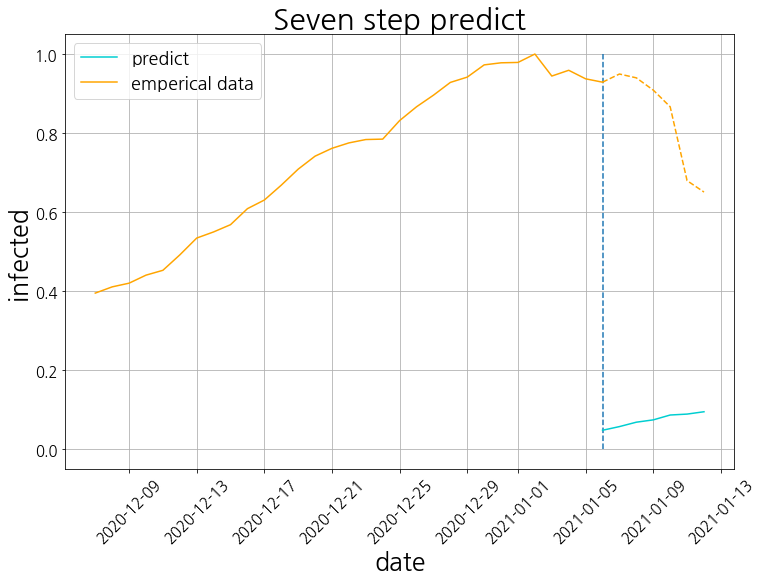

In [274]:
plt.figure(figsize = (12,8))
plt.title("Seven step predict", size = 30)
plt.xlabel("date", fontsize = 25)
plt.ylabel("infected", fontsize = 25)
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)

day = 10

plt.plot(states_new.index[train_size+val_size+day*yseq_length:train_size+val_size+(day+1)*yseq_length], preds[day], c = "darkturquoise",label = "predict")
plt.plot(states_new.index[train_size+val_size+day*yseq_length-xseq_length:train_size+val_size+day*yseq_length+1], infect_reprod["infected"][train_size+val_size+day*yseq_length-xseq_length:train_size+val_size+day*yseq_length+1], c = "orange", label = "emperical data")
plt.plot(states_new.index[train_size+val_size+day*yseq_length:train_size+val_size+(day+1)*yseq_length], infect_reprod["infected"][train_size+val_size+day*yseq_length:train_size+val_size+(day+1)*yseq_length], "--", c = "orange")
plt.vlines(states_new.index[train_size+val_size+day*yseq_length], 0, 1, linestyles="dashed")
plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show()

In [266]:
infect_reprod["infected"][train_size+val_size+day*yseq_length:train_size+val_size+(day+1)*yseq_length] - preds[day]

date
2020-10-28   -0.006677
2020-10-29   -0.013087
2020-10-30   -0.017662
2020-10-31   -0.017709
2020-11-01   -0.023407
2020-11-02   -0.023151
2020-11-03   -0.030827
Name: infected, dtype: float64

# version paper

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def create_sequences(data, xseq_length, yseq_length):
    x = []
    y = []
    
    for i in range(0, len(data)):
        end_idx = i+xseq_length+yseq_length
        if end_idx > len(data):
            break
        
        sequence = data.iloc[i:end_idx].copy().values

        x.append(sequence[:xseq_length])
        y.append(sequence[xseq_length:])
    return np.array(x), np.array(y)

In [56]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, xseq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers   #number of layers
        self.input_size = input_size   #input size
        self.hidden_size = hidden_size #hidden state
        self.xseq_length = xseq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=0.3 ,batch_first=True)
        self.fc =  nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def reset_hidden_state(self, batch_size):
        self.hidden = (
            torch.zeros(self.num_layers, batch_size, self.hidden_size),
            torch.zeros(self.num_layers, batch_size, self.hidden_size),
        )
        
    def forward(self,x):
        # Propagate input through LSTM
        batch_size = x.size(0)
        output, self.hidden = self.lstm(x, self.hidden) #lstm with input, hidden, and internal state
        out = self.fc(output[:,-1].contiguous().view(batch_size, -1))
        out = self.sigmoid(out)
        return out

In [57]:
def train_model(model, train_data, train_labels, batch_size, num_epochs=100, verbose = 10):
    loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max= len(train_data) , eta_min=1e-5)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):
        epoch_loss = 0
        p = np.random.permutation(len(train_data))
        for i in range(0, len(train_data), batch_size):
            if i+batch_size < len(train_data):
                X_batch = train_data[p][i:i+batch_size,:,:]
                y_batch = train_labels[p][i:i+batch_size,:]

                model.reset_hidden_state(batch_size) # seq 별 hidden state reset

                # train loss
                y_pred = model(X_batch)
                loss = loss_fn(y_pred.view(-1), y_batch.view(-1)) # 1개의 step에 대한 loss

                # update weights
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                scheduler.step() 

                epoch_loss += 1000*loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

    return model, train_hist, val_hist

In [58]:
confirmed = pd.read_csv("data/csse_covid_19_data/time_series_covid19_confirmed_global.csv")
confirmed = confirmed.drop(["Lat", "Long"], axis = 1).groupby(["Country/Region"]).sum().transpose()
confirmed.index = pd.to_datetime(confirmed.index)
recovered = pd.read_csv("data/csse_covid_19_data/time_series_covid19_recovered_global.csv")
recovered = recovered.drop(["Lat", "Long"], axis = 1).groupby(["Country/Region"]).sum().transpose()
recovered.index = pd.to_datetime(recovered.index)
death = pd.read_csv("data/csse_covid_19_data/time_series_covid19_deaths_global.csv")
death = death.drop(["Lat", "Long"], axis = 1).groupby(["Country/Region"]).sum().transpose()
death.index = pd.to_datetime(death.index)
latlong = pd.read_csv("data/csse_covid_19_data/time_series_covid19_confirmed_global.csv", usecols=[0,1,2,3]).groupby(["Country/Region"]).sum()

In [59]:
print(confirmed.shape)
print(recovered.shape)
print(death.shape)

(537, 195)
(538, 195)
(538, 195)


In [60]:
training_country = list(confirmed.columns)[:5]
testing_country = 'Korea, South'
# training_country.remove(testing_country)
data1 = pd.DataFrame({"confirmed" : [], "recovered" : [], "death" : [], "lat" : [] ,"long" : []})

for i in training_country:
    confirm = (confirmed[i]-recovered[i]-death[i]).fillna(method='ffill').rolling(window = 7, min_periods=1).mean()
    data1 = pd.concat([data1, pd.DataFrame({"confirmed" : confirm, "recovered" : recovered[i], "death" : death[i], "lat" : latlong.loc[i, "Lat"], "long" : latlong.loc[i, "Long"]})])
data1 = data1.fillna(method='ffill')
data1

,confirmed,recovered,death,lat,long
2020-01-22,0.000000,0.0,0.0,33.93911,67.709953
2020-01-23,0.000000,0.0,0.0,33.93911,67.709953
2020-01-24,0.000000,0.0,0.0,33.93911,67.709953
2020-01-25,0.000000,0.0,0.0,33.93911,67.709953
2020-01-26,0.000000,0.0,0.0,33.93911,67.709953
...,...,...,...,...,...
2021-07-08,4624.714286,34100.0,925.0,-11.20270,17.873900
2021-07-09,4608.428571,34169.0,928.0,-11.20270,17.873900
2021-07-10,4595.000000,34298.0,929.0,-11.20270,17.873900
2021-07-11,4601.857143,34327.0,935.0,-11.20270,17.873900


In [61]:
confirm = (confirmed[testing_country]-recovered[testing_country]-death[testing_country]).fillna(method='ffill').rolling(window = 7, min_periods=1).mean()
data2 = pd.DataFrame({"confirmed" : confirmed[testing_country]-recovered[testing_country]-death[testing_country], "recovered" : recovered[testing_country], "death" : death[testing_country], "lat" : latlong.loc[testing_country, "Lat"], "long" : latlong.loc[testing_country, "Long"]})
data2 = data2.fillna(method='ffill')
data2

,confirmed,recovered,death,lat,long
2020-01-22,1.0,0,0,35.907757,127.766922
2020-01-23,1.0,0,0,35.907757,127.766922
2020-01-24,2.0,0,0,35.907757,127.766922
2020-01-25,2.0,0,0,35.907757,127.766922
2020-01-26,3.0,0,0,35.907757,127.766922
...,...,...,...,...,...
2021-07-08,10810.0,152498,2036,35.907757,127.766922
2021-07-09,11531.0,153153,2038,35.907757,127.766922
2021-07-10,12243.0,153760,2043,35.907757,127.766922
2021-07-11,12915.0,154187,2044,35.907757,127.766922


In [62]:
date = pd.DataFrame({"confirmed" : confirmed[testing_country]-recovered[testing_country]-death[testing_country]})
date = date.fillna(method='ffill')
date

,confirmed
2020-01-22,1.0
2020-01-23,1.0
2020-01-24,2.0
2020-01-25,2.0
2020-01-26,3.0
...,...
2021-07-08,10810.0
2021-07-09,11531.0
2021-07-10,12243.0
2021-07-11,12915.0


In [63]:
#input splitting################################################################################################
n_features = 5    # this is number of parallel inputs
n_timesteps = 100 # this is number of timesteps
xseq_length = 70
yseq_length = 30

X_train, Y_train = create_sequences(data1, xseq_length, yseq_length)

print (X_train.shape, Y_train.shape)

(2591, 70, 5) (2591, 30, 5)


In [64]:
#normalization##################################################################################################
alld1 = np.concatenate((X_train, Y_train),1)
alld1 = alld1.reshape(alld1.shape[0]*alld1.shape[1], alld1.shape[2])

scaler1 = MinMaxScaler()
scaler1.fit(alld1)

X_train = [scaler1.transform(x) for x in X_train]
y_train = [scaler1.transform(y) for y in Y_train]

X_train = np.array(X_train)
y_train = np.array(y_train)[:,:,0]

In [65]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

In [66]:
num_epochs = 500        #number of epochs
learning_rate = 0.001  #lr
input_size = n_features #number of features
hidden_size = 10        #number of features in hidden state
num_layers = 4          #number of stacked lstm layers
num_classes = 30        #number of output classes
batch_size = 7          #number of batch size

In [67]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, xseq_length)

In [68]:
lstm1, train_hist, val_hist = train_model(
    lstm1,
    X_train_tensor,
    y_train_tensor,
    batch_size,
    num_epochs=num_epochs,
    verbose=10
)

Epoch 0 train loss: 11.255649952933233
Epoch 10 train loss: 3.1927219799254987
Epoch 20 train loss: 1.4329938535342752
Epoch 30 train loss: 1.1568509913872769
Epoch 40 train loss: 0.926939377306949
Epoch 50 train loss: 0.506428628871248
Epoch 60 train loss: 0.4052644186376514
Epoch 70 train loss: 0.7271344601342024
Epoch 80 train loss: 0.4320991747207984
Epoch 90 train loss: 0.2877605918431089
Epoch 100 train loss: 0.46521277756988516
Epoch 110 train loss: 0.3944924948049923
Epoch 120 train loss: 0.2529086719151441
Epoch 130 train loss: 0.3756151867985543
Epoch 140 train loss: 0.6890137513513538
Epoch 150 train loss: 0.3276827111221441
Epoch 160 train loss: 0.23028014907981154
Epoch 170 train loss: 0.26156242289719017
Epoch 180 train loss: 0.3317666455911426
Epoch 190 train loss: 0.19415346184002816
Epoch 200 train loss: 0.2008612244188325
Epoch 210 train loss: 0.41293185577023434
Epoch 220 train loss: 0.3422819053251122
Epoch 230 train loss: 0.16732555650202835
Epoch 240 train loss: 0

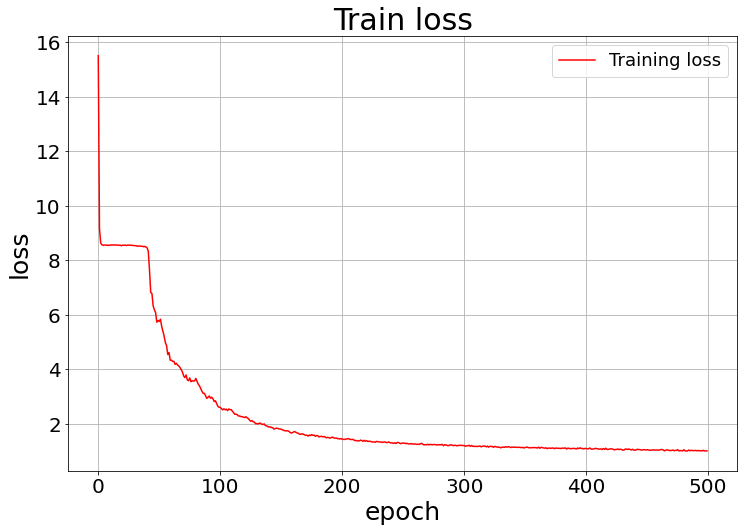

In [16]:
plt.figure(figsize = (12,8))
plt.title("Train loss", size = 30)
plt.xlabel("epoch", fontsize = 25)
plt.ylabel("loss", fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.plot(train_hist, c = "r", label="Training loss")

plt.grid()
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show()

In [84]:
X_test, Y_test = create_sequences(data2, xseq_length, yseq_length)

alld2 = np.concatenate((X_test, Y_test),1)
alld2 = alld2.reshape(alld2.shape[0]*alld2.shape[1], alld2.shape[2])

scaler2 = MinMaxScaler()
scaler2.fit(alld2)

X_test = [scaler2.transform(x) for x in X_test]
y_test = [scaler2.transform(y) for y in Y_test]

X_test = np.array(X_test)
y_test = np.array(y_test)[:,:,0]

X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

with torch.no_grad():
    preds = []
    trues  = []
    for i in range(len(X_test_tensor)):
        lstm1.reset_hidden_state(1) # seq 별 hidden state reset
        pred = lstm1(torch.unsqueeze(X_test_tensor[i], 0))
        preds.append(scaler2.inverse_transform(np.tile(np.array(pred).reshape(-1,1), (1,5)))[:,0])
        trues.append(scaler2.inverse_transform(np.tile(torch.cat((X_test_tensor[i,:,0], y_test_tensor[i]), 0).numpy().reshape(-1,1), (1,5)))[:,0])

preds = np.array(preds)
trues = np.array(trues)

In [85]:
trues.shape

(439, 100)

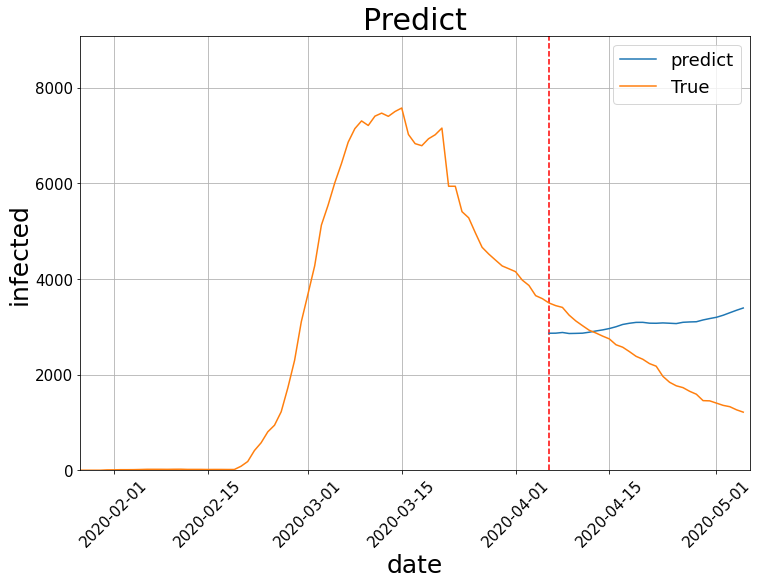

In [90]:
plt.figure(figsize = (12,8))
plt.title("Predict", size = 30)
plt.xlabel("date", fontsize = 25)
plt.ylabel("infected", fontsize = 25)
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)

day = 5

plt.plot(date.index[day+xseq_length:day+n_timesteps], preds[day], label = "predict")
plt.plot(date.index[day:day+n_timesteps], trues[day], label = "True")
plt.vlines(date.index[day+xseq_length],0 , max(np.concatenate([preds[day], trues[day]]))*1.2, colors="r", linestyles="dashed")
plt.grid()
plt.xlim(date.index[day], date.index[day+n_timesteps])
plt.ylim(0, max(np.concatenate([preds[day], trues[day]]))*1.2)
plt.legend(loc = "best", framealpha = 0.8, prop = {"size" : 18})
plt.show()